In [115]:
import sys
sys.path.append('../src')

import importlib
import dyn_accept_loop as dal
importlib.reload(dal)
import reject_inference as rinf
importlib.reload(rinf)
import helper as h
importlib.reload(h)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import torch

import lightgbm as lgbm

## Test importable Dynamic Acceptance Loop

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

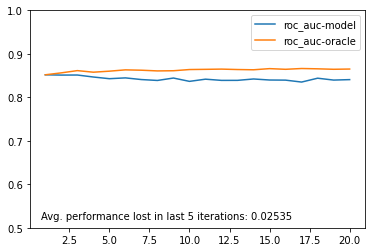

Sampling Bias: 0.02535


In [104]:
n_years = 20

model = lgbm.LGBMClassifier() # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)#rinf.EMsemisupervised)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

In [23]:
print(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years))

0.030117220239442456


## Test importable Autoencoder

In [105]:
import autoencoder as aenc
import var_autoencoder as vaenc
import importlib
importlib.reload(aenc)
importlib.reload(vaenc)

<module 'var_autoencoder' from 'c:\\Users\\haase.PAPMEIER\\InfSys\\reject-infer-autoencoder\\notebooks\\../src\\var_autoencoder.py'>

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=25, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=25, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=68, bias=True)
  )
)


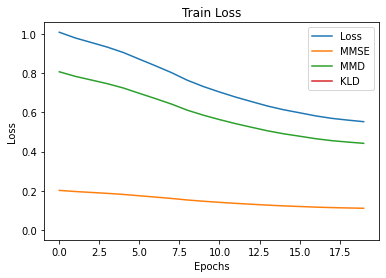

In [96]:
BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-3
LOSSFUNCWEIGHTS = [0.2,0.8, 0.0]  #[MMSE, KLDiv, MMD]

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

shape = [dataset.x.shape[1], 45, 25, 45, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = vaenc.train_var(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS)               

plt.figure()
plt.plot(train_loss, label='Loss')
plt.plot(train_loss_mmse, label='MMSE')
plt.plot(train_loss_mmd, label='MMD')
plt.plot(train_loss_kld, label='KLD')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 25)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 25)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 25)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 25)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 25)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 25)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 25)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 25)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 25)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 25)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 25)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 25)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

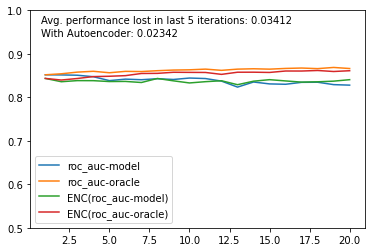

In [97]:
n_years = 20

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics2 = iteration[3]

last_n_years = 5
bias2 = h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.text(0.75, 0.97, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.text(0.75, 0.94, f'With Autoencoder: {round(bias2, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

## Plot Parameter-Dependencies

In [106]:
n_years = 20
model = lgbm.LGBMClassifier() # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)
datasetname = "gmsc.csv"

## ------------------------------------------------------------
## Get a Baseline Bias Measue without any reject inference
## ------------------------------------------------------------

sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

last_n_years = 5
baseline_bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
baseline_roc_auc = sum(metrics["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years
print(f'Baseline Sampling Bias: {round(baseline_bias, 5)}\nBaseline ROC-AUC: {round(baseline_roc_auc, 5)}')


Baseline Sampling Bias: 0.02321
Baseline ROC-AUC: 0.84192


In [ ]:

## -----------------------------------------------------------------------
## Loop through Autoencoder training and testing for a parameter
## -----------------------------------------------------------------------

BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-3

sampling_bias = []
roc_auc = []
startvalue = 10
stopvalue = 35
step = 2
for PARAM in range(startvalue, stopvalue, step):
    # Train Autoencoder
    LOSSFUNCWEIGHTS = [0.1, 0.9, 0.0]  #[MMSE, KLDiv, MMD]

    dataset = aenc.CreditscoringDataset(datasetname)      # load and prepare Dataset to Tensor
    data_loader = aenc.DataLoader(                       # create Dataloader for batching
        dataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

    shape = [dataset.x.shape[1], 45, PARAM, 45, dataset.x.shape[1]]  # define shape of Autoencoder PARAM = 25
    net = aenc.Autoencoder(shape)
    #print(net)
    net.to("cpu")

    train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS)

    # Simulate on encoded Data to measure sampling bias

    sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
    results_generator = sim.run()

    metrics2 = None
    for iteration in results_generator:
        #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
        metrics2 = iteration[3]


    sampling_bias.append(h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years))
    roc_auc.append(sum(metrics2["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)
    print(f'PARAM: {PARAM} | Sampling Bias: {round(sampling_bias[-1], 5)} // ROC-AUC: {round(roc_auc[-1], 5)}')

# Plot Results
x = range(startvalue, stopvalue, step)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(x, roc_auc, label = 'roc_auc')
axes[0].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
axes[0].legend()
axes[0].set_title("ROC-AUC of model")
axes[0].set_ylabel("ROC-AUC")
axes[0].set_xlabel("PARAM")

axes[1].plot(x, sampling_bias, label = 'sampling_bias')
axes[1].axhline(y = baseline_bias, color = 'r', label = 'baseline bias')
axes[1].legend()
axes[1].set_title("Sampling Bias")
axes[1].set_ylabel("Sampling Bias")
axes[1].set_xlabel("PARAM")
fig.tight_layout()


mit unseren geratenen 25 schon ganz gut ins schwarze getroffen :D

[0.00000000e+00 1.00050017e-03 8.03208550e-03 2.73678028e-02
 6.60923988e-02 1.33148453e-01 2.41102379e-01 4.09168762e-01
 6.68625110e-01 1.07300656e+00 1.71828183e+00 2.78482632e+00
 4.62938387e+00 7.99797903e+00 1.45490571e+01 2.82242838e+01
 5.90994085e+01 1.35046944e+02 3.40040078e+02 9.51414177e+02
 2.97995799e+03 1.05186477e+04 4.21072937e+04 1.92335169e+05
 1.00852458e+06 6.10732749e+06 4.29694509e+07 3.53360732e+08
 3.41690156e+09 3.90848203e+10]


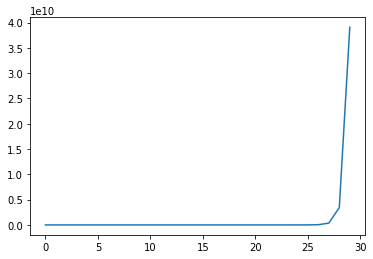

In [31]:
## Testvalues for kldiv size

import numpy as np

test_values = np.expm1(np.array(np.power(range(30),3),"float")/1000)

print(test_values)

plt.plot(test_values)

In [101]:
## -----------------------------------------------------------------------
## Loop through Autoencoder training and testing for a parameter
## -----------------------------------------------------------------------

test_values = np.array(range(0,11,1))/10
BATCH_SIZE = 2000
EPOCHS = 10
LR = 1e-3

sampling_bias = []
roc_auc = []

for PARAM in test_values:
    # Train Autoencoder
    LOSSFUNCWEIGHTS = [PARAM, 1-PARAM, 0.0]  #[MMSE, KLDiv, MMD]

    dataset = aenc.CreditscoringDataset(datasetname)      # load and prepare Dataset to Tensor
    data_loader = aenc.DataLoader(                       # create Dataloader for batching
        dataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

    shape = [dataset.x.shape[1], 45, 25, 45, dataset.x.shape[1]]  # define shape of Autoencoder PARAM = 25
    net2 = aenc.Autoencoder(shape)
    #print(net)
    net2.to("cpu")

    train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = vaenc.train_var(net2, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS)

    # Simulate on encoded Data to measure sampling bias

    sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=True, encoder=net2)#, rej_inf=rinf.EMsemisupervised)
    results_generator = sim.run()

    metrics6 = None
    for iteration in results_generator:
        #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
        metrics6 = iteration[3]


    sampling_bias.append(h.measure_bias(metrics6["oracle"]["holdout"]['roc_auc'], metrics6["model"]["holdout"]['roc_auc'], last_n_years))
    roc_auc.append(sum(metrics6["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)
    print(f'PARAM: {PARAM} | Sampling Bias: {round(sampling_bias[-1], 5)} // ROC-AUC: {round(roc_auc[-1], 5)}')


PARAM: 0.0 | Sampling Bias: 0.02217 // ROC-AUC: 0.83219
PARAM: 0.1 | Sampling Bias: 0.01969 // ROC-AUC: 0.83663
PARAM: 0.2 | Sampling Bias: 0.01155 // ROC-AUC: 0.84763
PARAM: 0.3 | Sampling Bias: 0.02478 // ROC-AUC: 0.83404
PARAM: 0.4 | Sampling Bias: 0.02685 // ROC-AUC: 0.8321
PARAM: 0.5 | Sampling Bias: 0.01513 // ROC-AUC: 0.84115
PARAM: 0.6 | Sampling Bias: 0.01891 // ROC-AUC: 0.8336
PARAM: 0.7 | Sampling Bias: 0.02292 // ROC-AUC: 0.83603
PARAM: 0.8 | Sampling Bias: 0.0274 // ROC-AUC: 0.83159
PARAM: 0.9 | Sampling Bias: 0.01986 // ROC-AUC: 0.83509
PARAM: 1.0 | Sampling Bias: 0.02711 // ROC-AUC: 0.8277


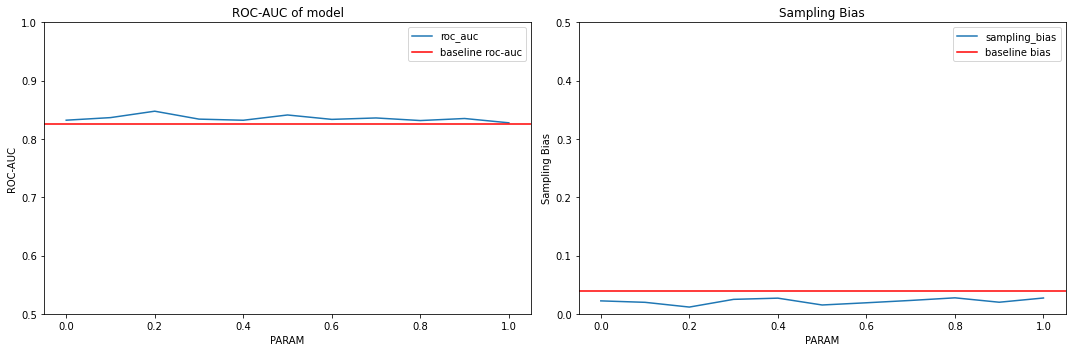

In [102]:

# Plot Results
x = test_values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(x, roc_auc, label = 'roc_auc')
#axes[0].set_xscale('log')
axes[0].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
axes[0].legend()
axes[0].set_title("ROC-AUC of model")
axes[0].set_ylabel("ROC-AUC")
axes[0].set_xlabel("PARAM")
axes[0].set_ylim([0.5, 1.0])

axes[1].plot(x, sampling_bias, label = 'sampling_bias')
#axes[1].set_xscale('log')
axes[1].axhline(y = baseline_bias, color = 'r', label = 'baseline bias')
axes[1].legend()
axes[1].set_title("Sampling Bias")
axes[1].set_ylabel("Sampling Bias")
axes[1].set_xlabel("PARAM")
axes[1].set_ylim([0.0, .5])
fig.tight_layout()


In [81]:
print(test_values[roc_auc > baseline_roc_auc])
print(test_values[roc_auc.index(max(roc_auc))])

[0.00000000e+00 1.33148453e-01 2.41102379e-01 4.09168762e-01
 1.07300656e+00 2.78482632e+00 4.62938387e+00 2.82242838e+01
 5.90994085e+01 2.97995799e+03 1.05186477e+04 4.21072937e+04
 6.10732749e+06 3.53360732e+08 3.90848203e+10]
6107327.490896726


In [83]:
print(test_values[sampling_bias < baseline_bias])
print(test_values[sampling_bias.index(min(sampling_bias))])

[0.00000000e+00 8.03208550e-03 2.73678028e-02 1.33148453e-01
 2.41102379e-01 4.09168762e-01 6.68625110e-01 1.07300656e+00
 1.71828183e+00 2.78482632e+00 4.62938387e+00 7.99797903e+00
 1.45490571e+01 2.82242838e+01 5.90994085e+01 9.51414177e+02
 2.97995799e+03 1.05186477e+04 4.21072937e+04 1.92335169e+05
 1.00852458e+06 6.10732749e+06 3.53360732e+08 3.41690156e+09
 3.90848203e+10]
4.629383874402168


In [137]:
## -----------------------------------------------------------------------
## Loop through Autoencoder training and testing for a parameter
## -----------------------------------------------------------------------

weight_test = np.array(range(0,3,1))/10
epochs_test = [1] + list(range(1,9,1))
shape_test = np.array(range(2,46,2))
BATCH_SIZE = 2000
#EPOCHS = 10
LR = 1e-3

sampling_bias = []
roc_auc = []

for weight in weight_test:
    for layer in shape_test:
        # Train Autoencoder
        LOSSFUNCWEIGHTS = [weight, 1-weight, 0.0]  #[MMSE, KLDiv, MMD]

        dataset = aenc.CreditscoringDataset(datasetname)      # load and prepare Dataset to Tensor
        data_loader = aenc.DataLoader(                       # create Dataloader for batching
            dataset, 
            batch_size=BATCH_SIZE,
            shuffle=True,
            drop_last=True
        )

        shape = [dataset.x.shape[1], 45, layer, 45, dataset.x.shape[1]]  # define shape of Autoencoder PARAM = 25
        net3 = aenc.Autoencoder(shape)
        #print(net)
        net3.to("cpu")

        for EPOCHS in epochs_test:

            train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = vaenc.train_var(net3, data_loader, 2**EPOCHS, LR, LOSSFUNCWEIGHTS)

            # Simulate on encoded Data to measure sampling bias

            sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=True, encoder=net3)#, rej_inf=rinf.EMsemisupervised)
            results_generator = sim.run()

            metrics7 = None
            for iteration in results_generator:
                #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
                metrics7 = iteration[3]


            sampling_bias.append(h.measure_bias(metrics7["oracle"]["holdout"]['roc_auc'], metrics7["model"]["holdout"]['roc_auc'], last_n_years))
            roc_auc.append(sum(metrics7["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)
            print(f'PARAM: {weight}, {layer}, {EPOCHS} | Sampling Bias: {round(sampling_bias[-1], 5)} // ROC-AUC: {round(roc_auc[-1], 5)}')


PARAM: 0.0, 2, 1 | Sampling Bias: 0.00732 // ROC-AUC: 0.64099
PARAM: 0.0, 2, 1 | Sampling Bias: 0.04593 // ROC-AUC: 0.707
PARAM: 0.0, 2, 2 | Sampling Bias: 0.022 // ROC-AUC: 0.77973


C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarn

PARAM: 0.0, 2, 3 | Sampling Bias: 0.03704 // ROC-AUC: 0.55279
PARAM: 0.0, 2, 4 | Sampling Bias: 0.03684 // ROC-AUC: 0.71747


C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarn

PARAM: 0.0, 2, 5 | Sampling Bias: 0.05916 // ROC-AUC: 0.69156


C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarn

PARAM: 0.0, 2, 6 | Sampling Bias: 0.01629 // ROC-AUC: 0.5819


C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarn

PARAM: 0.0, 2, 7 | Sampling Bias: 0.01465 // ROC-AUC: 0.64183
PARAM: 0.0, 2, 8 | Sampling Bias: 0.00313 // ROC-AUC: 0.77287
PARAM: 0.0, 4, 1 | Sampling Bias: 0.01995 // ROC-AUC: 0.75326
PARAM: 0.0, 4, 1 | Sampling Bias: 0.04005 // ROC-AUC: 0.73446
PARAM: 0.0, 4, 2 | Sampling Bias: 0.01458 // ROC-AUC: 0.75983
PARAM: 0.0, 4, 3 | Sampling Bias: 0.01978 // ROC-AUC: 0.77732
PARAM: 0.0, 4, 4 | Sampling Bias: 0.01897 // ROC-AUC: 0.79122
PARAM: 0.0, 4, 5 | Sampling Bias: 0.0271 // ROC-AUC: 0.72271
PARAM: 0.0, 4, 6 | Sampling Bias: 0.01957 // ROC-AUC: 0.73271
PARAM: 0.0, 4, 7 | Sampling Bias: 0.02788 // ROC-AUC: 0.79009
PARAM: 0.0, 4, 8 | Sampling Bias: 0.04454 // ROC-AUC: 0.71901
PARAM: 0.0, 6, 1 | Sampling Bias: 0.06057 // ROC-AUC: 0.7265
PARAM: 0.0, 6, 1 | Sampling Bias: 0.07921 // ROC-AUC: 0.73247
PARAM: 0.0, 6, 2 | Sampling Bias: 0.03513 // ROC-AUC: 0.78147
PARAM: 0.0, 6, 3 | Sampling Bias: 0.03179 // ROC-AUC: 0.79675
PARAM: 0.0, 6, 4 | Sampling Bias: 0.04365 // ROC-AUC: 0.78522
PARAM: 0.0

C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PARAM: 0.2, 2, 1 | Sampling Bias: 0.02337 // ROC-AUC: 0.70359


C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PARAM: 0.2, 2, 1 | Sampling Bias: 0.04285 // ROC-AUC: 0.64881


C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarn

PARAM: 0.2, 2, 2 | Sampling Bias: 0.0454 // ROC-AUC: 0.68051


C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haase.PAPMEIER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarn

PARAM: 0.2, 2, 3 | Sampling Bias: 0.1017 // ROC-AUC: 0.61499
PARAM: 0.2, 2, 4 | Sampling Bias: 0.08597 // ROC-AUC: 0.61136
PARAM: 0.2, 2, 5 | Sampling Bias: 0.06789 // ROC-AUC: 0.71134
PARAM: 0.2, 2, 6 | Sampling Bias: 0.05537 // ROC-AUC: 0.70788
PARAM: 0.2, 2, 7 | Sampling Bias: 0.01658 // ROC-AUC: 0.75157
PARAM: 0.2, 2, 8 | Sampling Bias: 0.01571 // ROC-AUC: 0.77515
PARAM: 0.2, 4, 1 | Sampling Bias: 0.0409 // ROC-AUC: 0.74228
PARAM: 0.2, 4, 1 | Sampling Bias: 0.02155 // ROC-AUC: 0.76746
PARAM: 0.2, 4, 2 | Sampling Bias: 0.01974 // ROC-AUC: 0.79858
PARAM: 0.2, 4, 3 | Sampling Bias: 0.03247 // ROC-AUC: 0.78165
PARAM: 0.2, 4, 4 | Sampling Bias: 0.02431 // ROC-AUC: 0.79866
PARAM: 0.2, 4, 5 | Sampling Bias: 0.04679 // ROC-AUC: 0.78807
PARAM: 0.2, 4, 6 | Sampling Bias: 0.05693 // ROC-AUC: 0.7801
PARAM: 0.2, 4, 7 | Sampling Bias: 0.06631 // ROC-AUC: 0.77462
PARAM: 0.2, 4, 8 | Sampling Bias: 0.04504 // ROC-AUC: 0.79295
PARAM: 0.2, 6, 1 | Sampling Bias: 0.03785 // ROC-AUC: 0.74115
PARAM: 0.2,

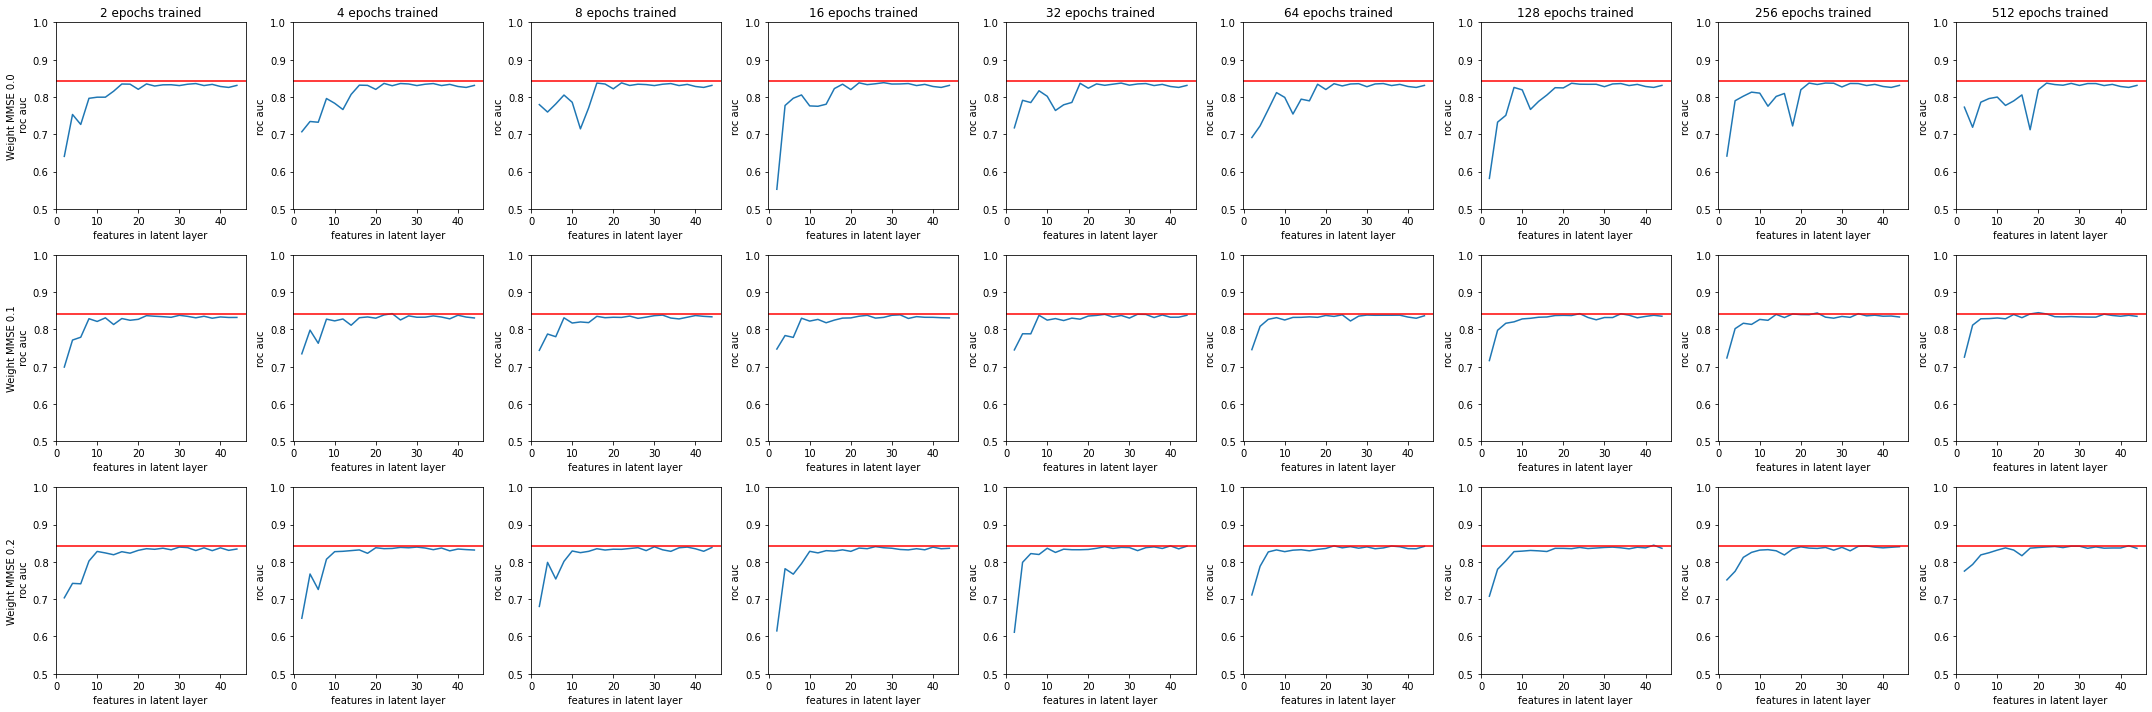

In [171]:
epochs_test = np.cumsum(2**np.array([1] + list(range(1,9,1))))

t_sampling_bias = torch.FloatTensor(sampling_bias).reshape(weight_test.shape[0],shape_test.shape[0],epochs_test.shape[0])
t_roc_auc = t_sampling_bias = torch.FloatTensor(roc_auc).reshape(weight_test.shape[0],shape_test.shape[0],epochs_test.shape[0])

fig, axes = plt.subplots(nrows=weight_test.shape[0], ncols=epochs_test.shape[0], figsize=(30, 10))
for w in range(weight_test.shape[0]):
    for e in range(epochs_test.shape[0]):
        axes[w][e].plot(shape_test, t_roc_auc[w][:,e], label = 'roc_auc')
        #axes[s][w].set_xscale('log')
        axes[w][e].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
        #axes[s][w].legend()
        axes[w][e].set_ylabel(f'Weight MMSE {weight_test[w]}\n roc auc') if e == 0 else axes[w][e].set_ylabel('roc auc')
        if w == 0: axes[w][e].set_title(f'{epochs_test[e]} epochs trained') 
        axes[w][e].set_xlabel("features in latent layer")
        axes[w][e].set_ylim([0.5, 1.0])
fig.tight_layout()

In [163]:
t_roc_auc.shape

torch.Size([3, 22, 9])

## Test basic Reject Inference Methods

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

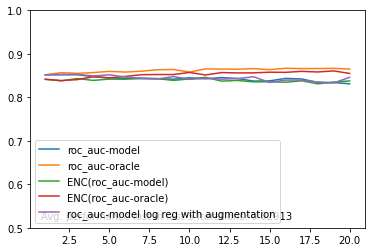

Sampling Bias: 0.02913


In [28]:
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=rinf.augmentation)
results_generator = sim.run()

metrics3 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics3 = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.plot(x, metrics3["model"]["holdout"]['roc_auc'], label = 'roc_auc-model log reg with augmentation')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 34)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 34)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 34)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 34)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 34)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 34)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 34)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 34)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 34)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 34)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 34)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 34)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

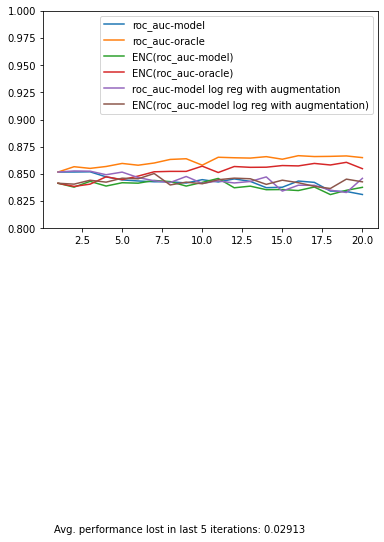

Sampling Bias: 0.02913


In [29]:
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net, rej_inf=rinf.augmentation)
results_generator = sim.run()

metrics4 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics4 = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.plot(x, metrics3["model"]["holdout"]['roc_auc'], label = 'roc_auc-model log reg with augmentation')
plt.plot(x, metrics4["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model log reg with augmentation)')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.8, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

In [35]:
metrics4["model"]["holdout"]['roc_auc']

[0.8608789133107744,
 0.8602977490179873,
 0.8601653942184185,
 0.8599629019353018,
 0.859719752792211,
 0.8595187565407383,
 0.8591413165571278,
 0.8589952334671783,
 0.858963816802653,
 0.8587888691021593,
 0.8587779568713438,
 0.8586799227977271,
 0.8586854669149963,
 0.8586214015598858,
 0.8585059431177089,
 0.8583310834190766,
 0.8583793964409935,
 0.8582475696525932,
 0.8583145390691305,
 0.8582458096153648]